## Merging Neighborhood Indicators and Neighborhood Boundary Data

In [1]:
import pandas as pd
import geopandas as gpd

/Users/micaobrien/opt/anaconda3/envs/uds/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
indicators = gpd.read_file('LAINC_2014.geojson')
indicators.Neighborho

0                                     Florence
1                          Watts/Green Meadows
2                 Florence/Broadway-Manchester
3      East Hollywood/Larchmont/Windsor Square
4                       Koreatown/Mid-Wilshire
                        ...                   
150                    Mostly not LA (Burbank)
151                    Mostly not LA (Burbank)
152             Mostly not LA (Universal City)
153                   Mostly not LA (Alhambra)
154                   Mostly not LA (Alhambra)
Name: Neighborho, Length: 155, dtype: object

In [5]:
indicators.loc[indicators['Neighborho'] == 'Westlake']

,OBJECTID,zipcode,Rank,Neighborho,IRS_Ratio,HH_Size,Per_White,Per_Colleg,Rent,Index_Scor,...,College__1,Gross_Rent,Gross_Re_1,MedInc4,HHChangAdj,Population,Populati_1,Populati_2,Evaluated,geometry
46,47,90057,31,Westlake,-38.126,-3.448,-0.778,4.082,25.599,0.409783,...,16.8,694,872,27132.46072,-0.709338,43986,45747,4.0,Yes,"POLYGON ((-118.26833 34.06127, -118.26839 34.0..."


In [1]:
import census
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format # avoid scientific notation

home = str(Path.home())
input_path = home+'/git/displacement-typologies/data/inputs/'
output_path = home+'/git/displacement-typologies/data/outputs/'

/Users/micaobrien/opt/anaconda3/envs/uds/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
key = '32ae7b3dab850d7a87a4cb50d7cf78cf21d9376d' #insert your API key here!
c = census.Census(key)

In [3]:
city_name = str(sys.argv[1])
if city_name == 'Chicago':
    state = '17'
    FIPS = ['031', '043', '089', '093', '097', '111', '197']
elif city_name == 'Atlanta':
    state = '13'
    FIPS = ['057', '063', '067', '089', '097', '113', '121', '135', '151', '247']
elif city_name == 'Denver':
    state = '08'
    FIPS = ['001', '005', '013', '014', '019', '031', '035', '047', '059']
elif city_name == 'Memphis':
    state = ['28', '47']
    FIPS = {'28':['033', '093'], '47': ['047', '157']}
elif city_name == 'Los Angeles':
    state = '06'
    FIPS = ['037', '059', '073']
elif city_name == 'San Francisco':
    state = '06'
    FIPS = ['001', '013', '041', '055', '067', '075', '077', '081', '085', '087', '095', '097', '113']
elif city_name == 'Seattle':
    state = '53'
    FIPS = ['033', '053', '061']
elif city_name == 'Cleveland':
    state = '39'
    FIPS = ['035', '055', '085', '093', '103']
elif city_name == 'Boston':
    state = ['25', '33']
    FIPS = {'25': ['009', '017', '021', '023', '025'], '33': ['015', '017']}
else:
    print ('There is not information for the selected city')

There is not information for the selected city


In [4]:
def filter_FIPS(df):
    if (city_name not in ('Memphis', 'Boston')):
        df = df[df['county'].isin(FIPS)]
    else:
        fips_list = []
        for i in state:
            county = FIPS[i]
            a = list((df['FIPS'][(df['county'].isin(county))&(df['state']==i)]))
            fips_list = fips_list + a
        df = df[df['FIPS'].isin(fips_list)]
    return df

In [7]:
#if (city_name not in ('Memphis', 'Boston')):
    #sql_query='state:{} county:*'.format(state)
#else:
    #sql_query_1='state:{} county:*'.format(state[0])
    #sql_query_2='state:{} county:*'.format(state[1])

In [8]:
df_vars_18=['B03002_001E',
            'B03002_003E',
            'B19001_001E',
            'B19013_001E',
            'B25077_001E',
            'B25077_001M',
            'B25064_001E',
            'B25064_001M',
            'B15003_001E',
            'B15003_022E',
            'B15003_023E',
            'B15003_024E',
            'B15003_025E',
            'B25034_001E',
            'B25034_010E',
            'B25034_011E',
            'B25003_002E',
            'B25003_003E',
            'B25105_001E',
            'B06011_001E']

In [9]:
var_str = 'B19001'
var_list = []
for i in range (1, 18):
    var_list.append(var_str+'_'+str(i).zfill(3)+'E')
df_vars_18 = df_vars_18 + var_list

# Migration - see notes
var_str = 'B07010'
var_list = []
for i in list(range(25,34))+list(range(36, 45))+list(range(47, 56))+list(range(58, 67)):
    var_list.append(var_str+'_'+str(i).zfill(3)+'E')
df_vars_18 = df_vars_18 + var_list

In [11]:
#if (city_name not in ('Memphis', 'Boston')):
   # var_dict_acs5 = c.acs5.get(df_vars_18, geo = {'for': 'tract:*',
              #                   'in': sql_query}, year=2018)
#else:
   # var_dict_1 = c.acs5.get(df_vars_18, geo = {'for': 'tract:*',
    #                             'in': sql_query_1} , year=2018)
   # var_dict_2 = (c.acs5.get(df_vars_18, geo = {'for': 'tract:*',
   #                              'in': sql_query_2}, year=2018))
   # var_dict_acs5 = var_dict_1+var_dict_2

In [12]:
df_vars_18 = pd.DataFrame.from_dict(var_dict_acs5)
df_vars_18['FIPS']=df_vars_18['state']+df_vars_18['county']+df_vars_18['tract']
df_vars_18 = filter_FIPS(df_vars_18)

### Renames variables

df_vars_18 = df_vars_18.rename(columns = {'B03002_001E':'pop_18',
                                          'B03002_003E':'white_18',
                                          'B19001_001E':'hh_18',
                                          'B19013_001E':'hinc_18',
                                          'B25077_001E':'mhval_18',
                                          'B25077_001M':'mhval_18_se',
                                          'B25064_001E':'mrent_18',
                                          'B25064_001M':'mrent_18_se',
                                          'B25003_002E':'ohu_18',
                                          'B25003_003E':'rhu_18',
                                          'B25105_001E':'mmhcosts_18',
                                          'B15003_001E':'total_25_18',
                                          'B15003_022E':'total_25_col_bd_18',
                                          'B15003_023E':'total_25_col_md_18',
                                          'B15003_024E':'total_25_col_pd_18',
                                          'B15003_025E':'total_25_col_phd_18',
                                          'B25034_001E':'tot_units_built_18',
                                          'B25034_010E':'units_40_49_built_18',
                                          'B25034_011E':'units_39_early_built_18',
                                          'B07010_025E':'mov_wc_w_income_18',
                                          'B07010_026E':'mov_wc_9000_18',
                                          'B07010_027E':'mov_wc_15000_18',
                                          'B07010_028E':'mov_wc_25000_18',
                                          'B07010_029E':'mov_wc_35000_18',
                                          'B07010_030E':'mov_wc_50000_18',
                                          'B07010_031E':'mov_wc_65000_18',
                                          'B07010_032E':'mov_wc_75000_18',
                                          'B07010_033E':'mov_wc_76000_more_18',
                                          'B07010_036E':'mov_oc_w_income_18',
                                          'B07010_037E':'mov_oc_9000_18',
                                          'B07010_038E':'mov_oc_15000_18',
                                          'B07010_039E':'mov_oc_25000_18',
                                          'B07010_040E':'mov_oc_35000_18',
                                          'B07010_041E':'mov_oc_50000_18',
                                          'B07010_042E':'mov_oc_65000_18',
                                          'B07010_043E':'mov_oc_75000_18',
                                          'B07010_044E':'mov_oc_76000_more_18',
                                          'B07010_047E':'mov_os_w_income_18',
                                          'B07010_048E':'mov_os_9000_18',
                                          'B07010_049E':'mov_os_15000_18',
                                          'B07010_050E':'mov_os_25000_18',
                                          'B07010_051E':'mov_os_35000_18',
                                          'B07010_052E':'mov_os_50000_18',
                                          'B07010_053E':'mov_os_65000_18',
                                          'B07010_054E':'mov_os_75000_18',
                                          'B07010_055E':'mov_os_76000_more_18',
                                          'B07010_058E':'mov_fa_w_income_18',
                                          'B07010_059E':'mov_fa_9000_18',
                                          'B07010_060E':'mov_fa_15000_18',
                                          'B07010_061E':'mov_fa_25000_18',
                                          'B07010_062E':'mov_fa_35000_18',
                                          'B07010_063E':'mov_fa_50000_18',
                                          'B07010_064E':'mov_fa_65000_18',
                                          'B07010_065E':'mov_fa_75000_18',
                                          'B07010_066E':'mov_fa_76000_more_18',
                                          'B06011_001E':'iinc_18',
                                          'B19001_002E':'I_10000_18',
                                          'B19001_003E':'I_15000_18',
                                          'B19001_004E':'I_20000_18',
                                          'B19001_005E':'I_25000_18',
                                          'B19001_006E':'I_30000_18',
                                          'B19001_007E':'I_35000_18',
                                          'B19001_008E':'I_40000_18',
                                          'B19001_009E':'I_45000_18',
                                          'B19001_010E':'I_50000_18',
                                          'B19001_011E':'I_60000_18',
                                          'B19001_012E':'I_75000_18',
                                          'B19001_013E':'I_100000_18',
                                          'B19001_014E':'I_125000_18',
                                          'B19001_015E':'I_150000_18',
                                          'B19001_016E':'I_200000_18',
                                          'B19001_017E':'I_201000_18'})

NameError: name 'var_dict_acs5' is not defined

In [40]:
var_sf1=['P004001',
         'P004005',
         'H004001',
         'H004002',
         'H004003']

var_sf3=['P037001',
         'P037015',
         'P037016',
         'P037017',
         'P037018',
         'P037032',
         'P037033',
         'P037034',
         'P037035',
         'H085001',
         'H063001',
         'P052001',
         'P053001']

var_str = 'P0'
var_list = []
for i in range (2, 18):
    var_list.append(var_str+str(52000+i))

var_sf3 = var_sf3 + var_list

In [47]:
# SF1
if (city_name not in ('Memphis', 'Boston')):
    var_dict_sf1 = c.sf1.get(var_sf1, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=2000)
else:
    var_dict_1 = c.sf1.get(var_sf1, geo = {'for': 'tract:*',
                                 'in': sql_query_1}, year=2000)
    var_dict_2 = (c.sf1.get(var_sf1, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=2000))
    var_dict_sf1 = var_dict_1+var_dict_2

# SF3
if (city_name not in ('Memphis', 'Boston')):
    var_dict_sf3 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=2000)
else:
    var_dict_1 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_1}, year=2000)
    var_dict_2 = (c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=2000))
    var_dict_sf3 = var_dict_1+var_dict_2

AttributeError: 'Census' object has no attribute 'sf3'

In [42]:
df_vars_sf1 = pd.DataFrame.from_dict(var_dict_sf1)
df_vars_sf3 = pd.DataFrame.from_dict(var_dict_sf3)
df_vars_sf1['FIPS']=df_vars_sf1['state']+df_vars_sf1['county']+df_vars_sf1['tract']
df_vars_sf3['FIPS']=df_vars_sf3['state']+df_vars_sf3['county']+df_vars_sf3['tract']
df_vars_sf1 = filter_FIPS(df_vars_sf1)
df_vars_sf3 = filter_FIPS(df_vars_sf3)

### Renames variables

df_vars_sf1 = df_vars_sf1.rename(columns = {'P004001':'pop_00',
                                            'P004005':'white_00',
                                            'H004001':'hu_00',
                                            'H004002':'ohu_00',
                                            'H004003':'rhu_00'})

df_vars_sf3 = df_vars_sf3.rename(columns = {'P037001':'total_25_00',
                                            'P037015':'male_25_col_bd_00',
                                            'P037016':'male_25_col_md_00',
                                            'P037017':'male_25_col_psd_00',
                                            'P037018':'male_25_col_phd_00',
                                            'P037032':'female_25_col_bd_00',
                                            'P037033':'female_25_col_md_00',
                                            'P037034':'female_25_col_psd_00',
                                            'P037035':'female_25_col_phd_00',
                                            'H085001':'mhval_00',
                                            'H063001':'mrent_00',
                                            'P052001':'hh_00',
                                            'P053001':'hinc_00',
                                            'P052002':'I_10000_00',
                                            'P052003':'I_15000_00',
                                            'P052004':'I_20000_00',
                                            'P052005':'I_25000_00',
                                            'P052006':'I_30000_00',
                                            'P052007':'I_35000_00',
                                            'P052008':'I_40000_00',
                                            'P052009':'I_45000_00',
                                            'P052010':'I_50000_00',
                                            'P052011':'I_60000_00',
                                            'P052012':'I_75000_00',
                                            'P052013':'I_100000_00',
                                            'P052014':'I_125000_00',
                                            'P052015':'I_150000_00',
                                            'P052016':'I_200000_00',
                                            'P052017':'I_201000_00'})

df_vars_00 = df_vars_sf1.merge(df_vars_sf3.drop(columns=['county', 'state', 'tract']), on = 'FIPS')


NameError: name 'var_dict_sf3' is not defined

In [43]:
var_sf3=['P0010001',
         'P0120001',
         'P0050001',
         'P0570001',
         'P0570002',
         'P0570003',
         'P0570004',
         'P0570005',
         'P0570006',
         'P0570007',
         'H061A001',
         'H043A001',
         'P080A001',
         'H0080001',
         'H0080002']

var_str = 'P0'
var_list = []
for i in range (1, 26):
    var_list.append(var_str+str(800000+i))

var_sf3 = var_sf3 + var_list

In [44]:
if (city_name not in ('Memphis', 'Boston')):
    var_dict_sf3 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=1990)
else:
    var_dict_1 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_1} , year=1990)
    var_dict_2 = (c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=1990))
    var_dict_sf3 = var_dict_1+var_dict_2

AttributeError: 'Census' object has no attribute 'sf3'

In [45]:
df_vars_90 = pd.DataFrame.from_dict(var_dict_sf3)
df_vars_90['FIPS']=df_vars_90['state']+df_vars_90['county']+df_vars_90['tract']
df_vars_90 = filter_FIPS(df_vars_90)

### Renames variables

df_vars_90 = df_vars_90.rename(columns = {'P0010001':'pop_90',
                                            'P0120001':'white_90',
                                            'P0050001':'hh_90',
                                            'P0570001':'total_25_col_9th_90',
                                            'P0570002':'total_25_col_12th_90',
                                            'P0570003':'total_25_col_hs_90',
                                            'P0570004':'total_25_col_sc_90',
                                            'P0570005':'total_25_col_ad_90',
                                            'P0570006':'total_25_col_bd_90',
                                            'P0570007':'total_25_col_gd_90',
                                            'H061A001':'mhval_90',
                                            'H043A001':'mrent_90',
                                            'P080A001':'hinc_90',
                                            'H0080001':'ohu_90',
                                            'H0080002':'rhu_90',
                                            'P0800001':'I_5000_90',
                                            'P0800002':'I_10000_90',
                                            'P0800003':'I_12500_90',
                                            'P0800004':'I_15000_90',
                                            'P0800005':'I_17500_90',
                                            'P0800006':'I_20000_90',
                                            'P0800007':'I_22500_90',
                                            'P0800008':'I_25000_90',
                                            'P0800009':'I_27500_90',
                                            'P0800010':'I_30000_90',
                                            'P0800011':'I_32500_90',
                                            'P0800012':'I_35000_90',
                                            'P0800013':'I_37500_90',
                                            'P0800014':'I_40000_90',
                                            'P0800015':'I_42500_90',
                                            'P0800016':'I_45000_90',
                                            'P0800017':'I_47500_90',
                                            'P0800018':'I_50000_90',
                                            'P0800019':'I_55000_90',
                                            'P0800020':'I_60000_90',
                                            'P0800021':'I_75000_90',
                                            'P0800022':'I_100000_90',
                                            'P0800023':'I_125000_90',
                                            'P0800024':'I_150000_90',
                                            'P0800025':'I_150001_90'})

NameError: name 'var_dict_sf3' is not defined

In [46]:
df_vars_summ = df_vars_18.merge(df_vars_12, on ='FIPS')

from pathlib import Path

#Export files to CSV
df_vars_summ.to_csv(output_path+"downloads/"+city_name.replace(" ", "")+'census_summ_2018.csv')
df_vars_90.to_csv(output_path+"downloads/"+city_name.replace(" ", "")+'census_90_2018.csv')
df_vars_00.to_csv(output_path+"downloads/"+city_name.replace(" ", "")+'census_00_2018.csv')

NameError: name 'df_vars_12' is not defined

In [13]:
# ==========================================================================
# ==========================================================================
# ==========================================================================
# Data Download
# Note: As of 2020, the Census API has been somewhat unreliable. We encourage
# everyone to save all their downloads so you don't run into delays while
# working on your project. Don't rely on the API to download everyday.
# ==========================================================================
# ==========================================================================
# ==========================================================================

#!/usr/bin/env python
# coding: utf-8

# ==========================================================================
# Import Libraries
# ==========================================================================

import census
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format # avoid scientific notation

home = str(Path.home())
input_path = home+'/git/displacement-typologies/data/inputs/'
output_path = home+'/git/displacement-typologies/data/outputs/'

# ==========================================================================
# Set API Key
# ==========================================================================

key = '32ae7b3dab850d7a87a4cb50d7cf78cf21d9376d' #insert your API key here!
c = census.Census(key)

# ==========================================================================
# Choose Cities
# ==========================================================================

# Choose City and Census Tracts of Interest
# --------------------------------------------------------------------------
# To get city data, run the following code in the terminal
# `python data.py <city name>`
# Example: python data.py Atlanta

city_name = str(sys.argv[1])
city_name = 'Atlanta'
#If reproducing for another city, add elif for
#that city & desired counties after last line

if city_name == 'Chicago':
    state = '17'
    FIPS = ['031', '043', '089', '093', '097', '111', '197']
elif city_name == 'Atlanta':
    state = '13'
    FIPS = ['057', '063', '067', '089', '097', '113', '121', '135', '151', '247']
elif city_name == 'Denver':
    state = '08'
    FIPS = ['001', '005', '013', '014', '019', '031', '035', '047', '059']
elif city_name == 'Memphis':
    state = ['28', '47']
    FIPS = {'28':['033', '093'], '47': ['047', '157']}
elif city_name == 'Los Angeles':
    state = '06'
    FIPS = ['037', '059', '073']
elif city_name == 'San Francisco':
    state = '06'
    FIPS = ['001', '013', '041', '055', '067', '075', '077', '081', '085', '087', '095', '097', '113']
elif city_name == 'Seattle':
    state = '53'
    FIPS = ['033', '053', '061']
elif city_name == 'Cleveland':
    state = '39'
    FIPS = ['035', '055', '085', '093', '103']
elif city_name == 'Boston':
    state = ['25', '33']
    FIPS = {'25': ['009', '017', '021', '023', '025'], '33': ['015', '017']}
else:
    print ('There is not information for the selected city')

if (city_name not in ('Memphis', 'Boston')):
    sql_query='state:{} county:*'.format(state)
else:
    sql_query_1='state:{} county:*'.format(state[0])
    sql_query_2='state:{} county:*'.format(state[1])

# Create Filter Function
# --------------------------------------------------------------------------
# Note - Memphis and Boston is different
# because they're located in 2 states

def filter_FIPS(df):
    if (city_name not in ('Memphis', 'Boston')):
        df = df[df['county'].isin(FIPS)]
    else:
        fips_list = []
        for i in state:
            county = FIPS[i]
            a = list((df['FIPS'][(df['county'].isin(county))&(df['state']==i)]))
            fips_list = fips_list + a
        df = df[df['FIPS'].isin(fips_list)]
    return df

# ==========================================================================
# Download Raw Data
# ==========================================================================

# Download ACS 2018 5-Year Estimates
# --------------------------------------------------------------------------

df_vars_18=['B03002_001E',
            'B03002_003E',
            'B19001_001E',
            'B19013_001E',
            'B25077_001E',
            'B25077_001M',
            'B25064_001E',
            'B25064_001M',
            'B15003_001E',
            'B15003_022E',
            'B15003_023E',
            'B15003_024E',
            'B15003_025E',
            'B25034_001E',
            'B25034_010E',
            'B25034_011E',
            'B25003_002E',
            'B25003_003E',
            'B25105_001E',
            'B06011_001E']

# Income categories - see notes
var_str = 'B19001'
var_list = []
for i in range (1, 18):
    var_list.append(var_str+'_'+str(i).zfill(3)+'E')
df_vars_18 = df_vars_18 + var_list

# Migration - see notes
var_str = 'B07010'
var_list = []
for i in list(range(25,34))+list(range(36, 45))+list(range(47, 56))+list(range(58, 67)):
    var_list.append(var_str+'_'+str(i).zfill(3)+'E')
df_vars_18 = df_vars_18 + var_list


# Run API query
# --------------------------------------------------------------------------
# NOTE: Memphis is located in two states so the query looks different
# same for Boston

if (city_name not in ('Memphis', 'Boston')):
    var_dict_acs5 = c.acs5.get(df_vars_18, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=2018)
else:
    var_dict_1 = c.acs5.get(df_vars_18, geo = {'for': 'tract:*',
                                 'in': sql_query_1} , year=2018)
    var_dict_2 = (c.acs5.get(df_vars_18, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=2018))
    var_dict_acs5 = var_dict_1+var_dict_2

# Convert and Rename Variables
# --------------------------------------------------------------------------

### Converts variables into dataframe and filters only FIPS of interest

df_vars_18 = pd.DataFrame.from_dict(var_dict_acs5)
df_vars_18['FIPS']=df_vars_18['state']+df_vars_18['county']+df_vars_18['tract']
df_vars_18 = filter_FIPS(df_vars_18)

### Renames variables

df_vars_18 = df_vars_18.rename(columns = {'B03002_001E':'pop_18',
                                          'B03002_003E':'white_18',
                                          'B19001_001E':'hh_18',
                                          'B19013_001E':'hinc_18',
                                          'B25077_001E':'mhval_18',
                                          'B25077_001M':'mhval_18_se',
                                          'B25064_001E':'mrent_18',
                                          'B25064_001M':'mrent_18_se',
                                          'B25003_002E':'ohu_18',
                                          'B25003_003E':'rhu_18',
                                          'B25105_001E':'mmhcosts_18',
                                          'B15003_001E':'total_25_18',
                                          'B15003_022E':'total_25_col_bd_18',
                                          'B15003_023E':'total_25_col_md_18',
                                          'B15003_024E':'total_25_col_pd_18',
                                          'B15003_025E':'total_25_col_phd_18',
                                          'B25034_001E':'tot_units_built_18',
                                          'B25034_010E':'units_40_49_built_18',
                                          'B25034_011E':'units_39_early_built_18',
                                          'B07010_025E':'mov_wc_w_income_18',
                                          'B07010_026E':'mov_wc_9000_18',
                                          'B07010_027E':'mov_wc_15000_18',
                                          'B07010_028E':'mov_wc_25000_18',
                                          'B07010_029E':'mov_wc_35000_18',
                                          'B07010_030E':'mov_wc_50000_18',
                                          'B07010_031E':'mov_wc_65000_18',
                                          'B07010_032E':'mov_wc_75000_18',
                                          'B07010_033E':'mov_wc_76000_more_18',
                                          'B07010_036E':'mov_oc_w_income_18',
                                          'B07010_037E':'mov_oc_9000_18',
                                          'B07010_038E':'mov_oc_15000_18',
                                          'B07010_039E':'mov_oc_25000_18',
                                          'B07010_040E':'mov_oc_35000_18',
                                          'B07010_041E':'mov_oc_50000_18',
                                          'B07010_042E':'mov_oc_65000_18',
                                          'B07010_043E':'mov_oc_75000_18',
                                          'B07010_044E':'mov_oc_76000_more_18',
                                          'B07010_047E':'mov_os_w_income_18',
                                          'B07010_048E':'mov_os_9000_18',
                                          'B07010_049E':'mov_os_15000_18',
                                          'B07010_050E':'mov_os_25000_18',
                                          'B07010_051E':'mov_os_35000_18',
                                          'B07010_052E':'mov_os_50000_18',
                                          'B07010_053E':'mov_os_65000_18',
                                          'B07010_054E':'mov_os_75000_18',
                                          'B07010_055E':'mov_os_76000_more_18',
                                          'B07010_058E':'mov_fa_w_income_18',
                                          'B07010_059E':'mov_fa_9000_18',
                                          'B07010_060E':'mov_fa_15000_18',
                                          'B07010_061E':'mov_fa_25000_18',
                                          'B07010_062E':'mov_fa_35000_18',
                                          'B07010_063E':'mov_fa_50000_18',
                                          'B07010_064E':'mov_fa_65000_18',
                                          'B07010_065E':'mov_fa_75000_18',
                                          'B07010_066E':'mov_fa_76000_more_18',
                                          'B06011_001E':'iinc_18',
                                          'B19001_002E':'I_10000_18',
                                          'B19001_003E':'I_15000_18',
                                          'B19001_004E':'I_20000_18',
                                          'B19001_005E':'I_25000_18',
                                          'B19001_006E':'I_30000_18',
                                          'B19001_007E':'I_35000_18',
                                          'B19001_008E':'I_40000_18',
                                          'B19001_009E':'I_45000_18',
                                          'B19001_010E':'I_50000_18',
                                          'B19001_011E':'I_60000_18',
                                          'B19001_012E':'I_75000_18',
                                          'B19001_013E':'I_100000_18',
                                          'B19001_014E':'I_125000_18',
                                          'B19001_015E':'I_150000_18',
                                          'B19001_016E':'I_200000_18',
                                          'B19001_017E':'I_201000_18'})

# Download ACS 2012 5-Year Estimates
# --------------------------------------------------------------------------
# Note: If additional cities are added, make sure to change create_lag_vars.r
# accordingly.

### List variables of interest

df_vars_12=['B25077_001E',
            'B25077_001M',
            'B25064_001E',
            'B25064_001M',
            'B07010_025E',
            'B07010_026E',
            'B07010_027E',
            'B07010_028E',
            'B07010_029E',
            'B07010_030E',
            'B07010_031E',
            'B07010_032E',
            'B07010_033E',
            'B07010_036E',
            'B07010_037E',
            'B07010_038E',
            'B07010_039E',
            'B07010_040E',
            'B07010_041E',
            'B07010_042E',
            'B07010_043E',
            'B07010_044E',
            'B07010_047E',
            'B07010_048E',
            'B07010_049E',
            'B07010_050E',
            'B07010_051E',
            'B07010_052E',
            'B07010_053E',
            'B07010_054E',
            'B07010_055E',
            'B07010_058E',
            'B07010_059E',
            'B07010_060E',
            'B07010_061E',
            'B07010_062E',
            'B07010_063E',
            'B07010_064E',
            'B07010_065E',
            'B07010_066E',
            'B06011_001E']

# Run API query
# --------------------------------------------------------------------------
# NOTE: Memphis is located in two states so the query looks different

if (city_name not in ('Memphis', 'Boston')):
    var_dict_acs5 = c.acs5.get(df_vars_12, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=2012)
else:
    var_dict_1 = c.acs5.get(df_vars_12, geo = {'for': 'tract:*',
                                 'in': sql_query_1} , year=2012)
    var_dict_2 = (c.acs5.get(df_vars_12, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=2012))
    var_dict_acs5 = var_dict_1+var_dict_2

# Convert and Rename Variabls
# --------------------------------------------------------------------------

### Converts variables into dataframe and filters only FIPS of interest

df_vars_12 = pd.DataFrame.from_dict(var_dict_acs5)
df_vars_12['FIPS']=df_vars_12['state']+df_vars_12['county']+df_vars_12['tract']
df_vars_12 = filter_FIPS(df_vars_12)

### Renames variables

df_vars_12 = df_vars_12.rename(columns = {'B25077_001E':'mhval_12',
                                          'B25077_001M':'mhval_12_se',
                                          'B25064_001E':'mrent_12',
                                          'B25064_001M':'mrent_12_se',
                                          'B07010_025E':'mov_wc_w_income_12',
                                          'B07010_026E':'mov_wc_9000_12',
                                          'B07010_027E':'mov_wc_15000_12',
                                          'B07010_028E':'mov_wc_25000_12',
                                          'B07010_029E':'mov_wc_35000_12',
                                          'B07010_030E':'mov_wc_50000_12',
                                          'B07010_031E':'mov_wc_65000_12',
                                          'B07010_032E':'mov_wc_75000_12',
                                          'B07010_033E':'mov_wc_76000_more_12',
                                          'B07010_036E':'mov_oc_w_income_12',
                                          'B07010_037E':'mov_oc_9000_12',
                                          'B07010_038E':'mov_oc_15000_12',
                                          'B07010_039E':'mov_oc_25000_12',
                                          'B07010_040E':'mov_oc_35000_12',
                                          'B07010_041E':'mov_oc_50000_12',
                                          'B07010_042E':'mov_oc_65000_12',
                                          'B07010_043E':'mov_oc_75000_12',
                                          'B07010_044E':'mov_oc_76000_more_12',
                                          'B07010_047E':'mov_os_w_income_12',
                                          'B07010_048E':'mov_os_9000_12',
                                          'B07010_049E':'mov_os_15000_12',
                                          'B07010_050E':'mov_os_25000_12',
                                          'B07010_051E':'mov_os_35000_12',
                                          'B07010_052E':'mov_os_50000_12',
                                          'B07010_053E':'mov_os_65000_12',
                                          'B07010_054E':'mov_os_75000_12',
                                          'B07010_055E':'mov_os_76000_more_12',
                                          'B07010_058E':'mov_fa_w_income_12',
                                          'B07010_059E':'mov_fa_9000_12',
                                          'B07010_060E':'mov_fa_15000_12',
                                          'B07010_061E':'mov_fa_25000_12',
                                          'B07010_062E':'mov_fa_35000_12',
                                          'B07010_063E':'mov_fa_50000_12',
                                          'B07010_064E':'mov_fa_65000_12',
                                          'B07010_065E':'mov_fa_75000_12',
                                          'B07010_066E':'mov_fa_76000_more_12',
                                          'B06011_001E':'iinc_12'})

### Decennial Census 2000 Variables

var_sf1=['P004001',
         'P004005',
         'H004001',
         'H004002',
         'H004003']

var_sf3=['P037001',
         'P037015',
         'P037016',
         'P037017',
         'P037018',
         'P037032',
         'P037033',
         'P037034',
         'P037035',
         'H085001',
         'H063001',
         'P052001',
         'P053001']

var_str = 'P0'
var_list = []
for i in range (2, 18):
    var_list.append(var_str+str(52000+i))

var_sf3 = var_sf3 + var_list

# Run API query
# --------------------------------------------------------------------------
# NOTE: on certain days, Census API may argue about too many queries and this section
# may get hung up.

# SF1
if (city_name not in ('Memphis', 'Boston')):
    var_dict_sf1 = c.sf1.get(var_sf1, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=2000)
else:
    var_dict_1 = c.sf1.get(var_sf1, geo = {'for': 'tract:*',
                                 'in': sql_query_1}, year=2000)
    var_dict_2 = (c.sf1.get(var_sf1, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=2000))
    var_dict_sf1 = var_dict_1+var_dict_2

# SF3
if (city_name not in ('Memphis', 'Boston')):
    var_dict_sf3 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=2000)
else:
    var_dict_1 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_1}, year=2000)
    var_dict_2 = (c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=2000))
    var_dict_sf3 = var_dict_1+var_dict_2

# Convert and Rename Variables
# --------------------------------------------------------------------------

### Converts variables into dataframe and filters only FIPS of interest

df_vars_sf1 = pd.DataFrame.from_dict(var_dict_sf1)
df_vars_sf3 = pd.DataFrame.from_dict(var_dict_sf3)
df_vars_sf1['FIPS']=df_vars_sf1['state']+df_vars_sf1['county']+df_vars_sf1['tract']
df_vars_sf3['FIPS']=df_vars_sf3['state']+df_vars_sf3['county']+df_vars_sf3['tract']
df_vars_sf1 = filter_FIPS(df_vars_sf1)
df_vars_sf3 = filter_FIPS(df_vars_sf3)

### Renames variables

df_vars_sf1 = df_vars_sf1.rename(columns = {'P004001':'pop_00',
                                            'P004005':'white_00',
                                            'H004001':'hu_00',
                                            'H004002':'ohu_00',
                                            'H004003':'rhu_00'})

df_vars_sf3 = df_vars_sf3.rename(columns = {'P037001':'total_25_00',
                                            'P037015':'male_25_col_bd_00',
                                            'P037016':'male_25_col_md_00',
                                            'P037017':'male_25_col_psd_00',
                                            'P037018':'male_25_col_phd_00',
                                            'P037032':'female_25_col_bd_00',
                                            'P037033':'female_25_col_md_00',
                                            'P037034':'female_25_col_psd_00',
                                            'P037035':'female_25_col_phd_00',
                                            'H085001':'mhval_00',
                                            'H063001':'mrent_00',
                                            'P052001':'hh_00',
                                            'P053001':'hinc_00',
                                            'P052002':'I_10000_00',
                                            'P052003':'I_15000_00',
                                            'P052004':'I_20000_00',
                                            'P052005':'I_25000_00',
                                            'P052006':'I_30000_00',
                                            'P052007':'I_35000_00',
                                            'P052008':'I_40000_00',
                                            'P052009':'I_45000_00',
                                            'P052010':'I_50000_00',
                                            'P052011':'I_60000_00',
                                            'P052012':'I_75000_00',
                                            'P052013':'I_100000_00',
                                            'P052014':'I_125000_00',
                                            'P052015':'I_150000_00',
                                            'P052016':'I_200000_00',
                                            'P052017':'I_201000_00'})

df_vars_00 = df_vars_sf1.merge(df_vars_sf3.drop(columns=['county', 'state', 'tract']), on = 'FIPS')

### Download Decennial Census 1990 Variables

var_sf3=['P0010001',
         'P0120001',
         'P0050001',
         'P0570001',
         'P0570002',
         'P0570003',
         'P0570004',
         'P0570005',
         'P0570006',
         'P0570007',
         'H061A001',
         'H043A001',
         'P080A001',
         'H0080001',
         'H0080002']

var_str = 'P0'
var_list = []
for i in range (1, 26):
    var_list.append(var_str+str(800000+i))

var_sf3 = var_sf3 + var_list

# Run API Query
# --------------------------------------------------------------------------
# NOTE: Memphis is located in two states so the query looks different

# SF1 - All of the variables are found in the SF3
# SF3
if (city_name not in ('Memphis', 'Boston')):
    var_dict_sf3 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query}, year=1990)
else:
    var_dict_1 = c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_1} , year=1990)
    var_dict_2 = (c.sf3.get(var_sf3, geo = {'for': 'tract:*',
                                 'in': sql_query_2}, year=1990))
    var_dict_sf3 = var_dict_1+var_dict_2

# Convert and Rename Variables
# --------------------------------------------------------------------------

### Converts variables into dataframe and filters only FIPS of interest

df_vars_90 = pd.DataFrame.from_dict(var_dict_sf3)
df_vars_90['FIPS']=df_vars_90['state']+df_vars_90['county']+df_vars_90['tract']
df_vars_90 = filter_FIPS(df_vars_90)

### Renames variables

df_vars_90 = df_vars_90.rename(columns = {'P0010001':'pop_90',
                                            'P0120001':'white_90',
                                            'P0050001':'hh_90',
                                            'P0570001':'total_25_col_9th_90',
                                            'P0570002':'total_25_col_12th_90',
                                            'P0570003':'total_25_col_hs_90',
                                            'P0570004':'total_25_col_sc_90',
                                            'P0570005':'total_25_col_ad_90',
                                            'P0570006':'total_25_col_bd_90',
                                            'P0570007':'total_25_col_gd_90',
                                            'H061A001':'mhval_90',
                                            'H043A001':'mrent_90',
                                            'P080A001':'hinc_90',
                                            'H0080001':'ohu_90',
                                            'H0080002':'rhu_90',
                                            'P0800001':'I_5000_90',
                                            'P0800002':'I_10000_90',
                                            'P0800003':'I_12500_90',
                                            'P0800004':'I_15000_90',
                                            'P0800005':'I_17500_90',
                                            'P0800006':'I_20000_90',
                                            'P0800007':'I_22500_90',
                                            'P0800008':'I_25000_90',
                                            'P0800009':'I_27500_90',
                                            'P0800010':'I_30000_90',
                                            'P0800011':'I_32500_90',
                                            'P0800012':'I_35000_90',
                                            'P0800013':'I_37500_90',
                                            'P0800014':'I_40000_90',
                                            'P0800015':'I_42500_90',
                                            'P0800016':'I_45000_90',
                                            'P0800017':'I_47500_90',
                                            'P0800018':'I_50000_90',
                                            'P0800019':'I_55000_90',
                                            'P0800020':'I_60000_90',
                                            'P0800021':'I_75000_90',
                                            'P0800022':'I_100000_90',
                                            'P0800023':'I_125000_90',
                                            'P0800024':'I_150000_90',
                                            'P0800025':'I_150001_90'})

# ==========================================================================
# Export Files
# ==========================================================================
# Note: ouput paths can be altered by changing the 'output path variable above'

# Merge 2012 & 2018 files - same geometry
df_vars_summ = df_vars_18.merge(df_vars_12, on ='FIPS')

from pathlib import Path

#Export files to CSV
df_vars_summ.to_csv(output_path+"downloads/"+city_name.replace(" ", "")+'census_summ_2018.csv')
df_vars_90.to_csv(output_path+"downloads/"+city_name.replace(" ", "")+'census_90_2018.csv')
df_vars_00.to_csv(output_path+"downloads/"+city_name.replace(" ", "")+'census_00_2018.csv')

AttributeError: 'Census' object has no attribute 'sf3'

# Bringing in data directly 

In [14]:
df = gpd.read_file('scag.shp')
df.head()

,GEOID,Typology,geometry
0,6037128702.00,Stable Moderate/Mixed Income,"MULTIPOLYGON (((-118.44870 34.16486, -118.4399..."
1,6037131600.00,Stable Moderate/Mixed Income,"POLYGON ((-118.55355 34.22046, -118.54616 34.2..."
2,6037134104.00,At Risk of Becoming Exclusive,"POLYGON ((-118.57103 34.21559, -118.57101 34.2..."
3,6037134304.00,Advanced Gentrification,"POLYGON ((-118.60590 34.21966, -118.60589 34.2..."
4,6037242000.00,Low-Income/Susceptible to Displacement,"POLYGON ((-118.25364 33.94328, -118.24914 33.9..."


In [15]:
df.shape

(4553, 3)

<AxesSubplot:>

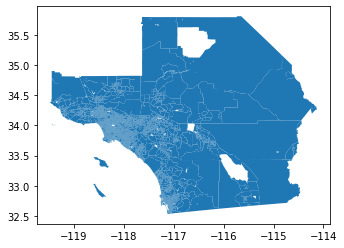

In [16]:
df.plot()

In [17]:
neighborhoods = gpd.read_file('LA_Times_Neighborhood_Boundaries (1).geojson')

In [19]:
join = gpd.sjoin(neighborhoods, df)
join

,OBJECTID,name,geometry,index_right,GEOID,Typology
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",692,6037221900.00,High Student Population
31,32,Exposition Park,"POLYGON ((-118.29155 34.01837, -118.28294 34.0...",692,6037221900.00,High Student Population
93,94,University Park,"POLYGON ((-118.27986 34.01848, -118.28294 34.0...",692,6037221900.00,High Student Population
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",4033,6037222100.00,Early/Ongoing Gentrification
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",81,6037222001.00,Advanced Gentrification
31,32,Exposition Park,"POLYGON ((-118.29155 34.01837, -118.28294 34.0...",81,6037222001.00,Advanced Gentrification
51,52,Jefferson Park,"POLYGON ((-118.31335 34.03721, -118.30900 34.0...",81,6037222001.00,Advanced Gentrification
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",3389,6037221810.00,High Student Population
93,94,University Park,"POLYGON ((-118.27986 34.01848, -118.28294 34.0...",3389,6037221810.00,High Student Population
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1351,6037222200.00,Ongoing Displacement


In [21]:
join.shape

(1992, 6)

In [39]:
Westlake = join.loc[join['name'] == 'Westlake']
Westlake.shape

(40, 6)

In [41]:
Westlake = Westlake.drop(['index_right'], axis=1)
Westlake

,OBJECTID,name,geometry,GEOID,Typology
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037207710.00,Advanced Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037210010.00,Advanced Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037209300.00,Early/Ongoing Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037209200.00,Early/Ongoing Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037208000.00,Low-Income/Susceptible to Displacement
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037211122.00,Early/Ongoing Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037192700.00,Early/Ongoing Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037208302.00,At Risk of Gentrification
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037208402.00,Ongoing Displacement
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037195710.00,Early/Ongoing Gentrification


<AxesSubplot:>

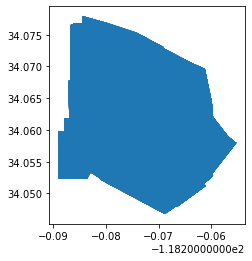

In [42]:
Westlake.plot()

In [49]:
Westlake.GEOID.is_unique

True

In [43]:
indicators = gpd.read_file('LAINC_2014.geojson')
indicators.shape

(155, 28)

In [50]:
indicators.zipcode.is_unique

True

In [47]:
join2 = gpd.sjoin(Westlake, indicators)
join2

,OBJECTID_left,name,geometry,GEOID,Typology,index_right,OBJECTID_right,zipcode,Rank,Neighborho,IRS_Ratio,HH_Size,Per_White,Per_Colleg,Rent,Index_Scor,IRS_Rati_1,IRS_Rati_2,HH_Incom_2,HH_Size_20,HH_Size_21,Percent_Wh,Percent__1,College_Pe,College__1,Gross_Rent,Gross_Re_1,MedInc4,HHChangAdj,Population,Populati_1,Populati_2,Evaluated
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037207710.00,Advanced Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037210010.00,Advanced Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037209300.00,Early/Ongoing Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037209200.00,Early/Ongoing Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037208000.00,Low-Income/Susceptible to Displacement,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037211122.00,Early/Ongoing Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037192700.00,Early/Ongoing Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037208302.00,At Risk of Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037208402.00,Ongoing Displacement,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes
106,107,Westlake,"POLYGON ((-118.25908 34.05389, -118.25984 34.0...",6037195710.00,Early/Ongoing Gentrification,13,14,90015,4,Downtown/Pico Union,-72.60,-16.89,5.96,13.48,46.15,0.65,5.09,1.39,28953,2.96,2.46,5.60,11.56,10.92,24.40,593,866,25478.61,13.64,15134,18226,20.40,Yes


In [45]:
join2.shape

(400, 33)

In [48]:
join2.GEOID.is_unique 

False

In [66]:
type(join2)

geopandas.geodataframe.GeoDataFrame

In [56]:
join2.duplicated()

106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False

In [58]:
join2.GEOID.duplicated(keep='first')

106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106    False
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True
106     True

In [72]:
join2.zipcode.unique()

array(['90015', '90006', '90005', '90010', '90057', '90020', '90004',
       '90017', '90012', '90026'], dtype=object)

In [64]:
index = join2.index_right

In [69]:
index = join2.index_right

In [71]:
index.unique()

array([13,  5,  4,  8, 46, 18,  3, 15, 10, 23])